# Setting Up

In [ ]:
%%time

!sudo apt-get update && apt-get install -y libspatialindex-dev
!pip install rtree
!pip install geopandas
!pip install plotly_express

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [814 kB]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,521 kB]
Get:13 http://ppa.launchpad.net/deadsnakes/ppa/ubunt

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib
import matplotlib.pyplot as plt 
import folium
import plotly_express as px

In [ ]:
# %cd ..

# %rm -r Lab_Downscaling

In [ ]:
# try:
!git init Lab_Downscaling
%cd Lab_Downscaling
!git remote add -f origin https://github.com/acm-ds-summer-school-2022/practical
!git config core.sparseCheckout true
!echo "day8" >> .git/info/sparse-checkout
!git pull origin main

In [ ]:
#except:
# !git clone https://github.com/dubeysarth/Lab_Downscaling
# %cd Lab_Downscaling

Cloning into 'Lab_Downscaling'...
remote: Enumerating objects: 12399, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 12399 (delta 3), reused 9 (delta 2), pack-reused 12388
Receiving objects: 100% (12399/12399), 322.04 MiB | 16.33 MiB/s, done.
Resolving deltas: 100% (3744/3744), done.
Checking out files: 100% (4410/4410), done.
/content/Lab_Downscaling


In [ ]:
'''
Import Libraries
'''
import xarray as xr
import netCDF4 as nc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import random
import itertools
from tqdm import tqdm

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
import tensorflow.keras.preprocessing as prep
from model import AugementedConvLSTM

[ 65.  70.  75.  80.  85.  90.  95. 100.]


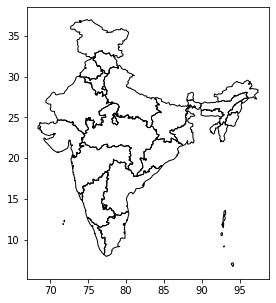

In [ ]:
fp = r"India Shapefile With Kashmir/India Shape/india_st.shp"
map_df = gpd.read_file(fp)
map_df = map_df.set_crs('EPSG:4326')
# map_df.crs
fig, ax = plt.subplots(1,1, figsize=(5,5))
map_df.plot(edgecolor="black", facecolor="None", ax = ax)
print(ax.get_xticks())

# Familiarizing with the Dataset

## Raw Precipitation Data (.nc format)

In [ ]:
filepath = r'Data/01/MIROC-ESM.nc'
ds = xr.open_dataset(filepath)
ds

<xarray.Dataset>
Dimensions:    (time: 2190, bnds: 2, lat: 12, lon: 12)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01T12:00:00 ... 2005-12-31T12:00:00
  * lat        (lat) float64 6.977 9.767 12.56 15.35 ... 29.3 32.09 34.88 37.67
  * lon        (lon) float64 67.5 70.31 73.12 75.94 ... 90.0 92.81 95.62 98.44
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    pr         (time, lat, lon) float32 ...
Attributes: (12/27)
    institution:            JAMSTEC (Japan Agency for Marine-Earth Science an...
    institute_id:           MIROC
    experiment_id:          historical
    source:                 MIROC-ESM 2010 atmosphere: MIROC-AGCM (MIROC-AGCM...
    model_id:               MIROC-ESM
    forcing:                GHG, SA, Oz, LU, Sl, Vl, MD, BC, OC
    ...                     ...
    table_id:               Table day (26 July 2011) f21c16b785432e6bd3f72e80...
    title:                  MIROC-ESM model output prepared for CMIP5 historical
    parent_experiment:      pre-industrial control
    modeling_realm:         atmos
    realization:            1
    cmor_version:           2.7.1

In [ ]:
filepath = r'Data/01/IMD_2000.nc'
ds1 = xr.open_dataset(filepath)
ds1

<xarray.Dataset>
Dimensions:  (time: 12, lat: 129, lon: 135)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2000-12-01
  * lat      (lat) float64 6.5 6.75 7.0 7.25 7.5 ... 37.5 37.75 38.0 38.25 38.5
  * lon      (lon) float64 66.5 66.75 67.0 67.25 67.5 ... 99.25 99.5 99.75 100.0
Data variables:
    rain     (time, lat, lon) float64 ...

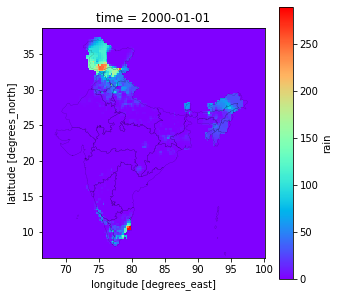

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
ds1['rain'][0,:,:].plot(cmap = 'rainbow', ax = ax)
map_df.plot(edgecolor="black", facecolor="None", ax = ax, linewidth = 0.1)

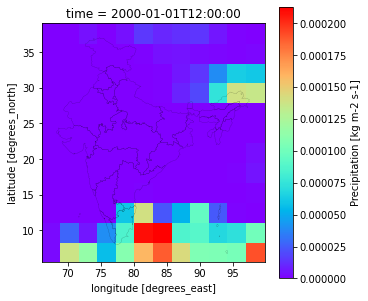

In [ ]:
'''
You have to consider that:
- 1 kg of rain water spread over 1 square meter of surface is 1 mm in thickness;
- there are 60X60X24=86400 seconds in one day.
Therefore, 1 kg/m2/s = 86400 mm/day.
'''
fig, ax = plt.subplots(1,1, figsize=(5,5))
ds['pr'][0,:,:].plot(cmap = 'rainbow', ax = ax)
map_df.plot(edgecolor="black", facecolor="None", ax = ax, linewidth = 0.1)

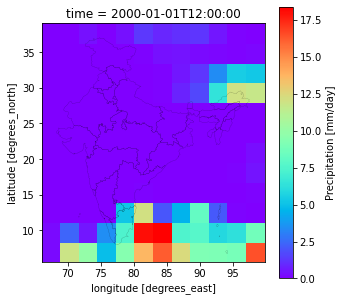

In [ ]:
ds2 = ds.copy(deep = True)
ds2['pr'] = ds2['pr'] * 86400
ds2.pr.attrs['units'] = 'mm/day'
ds2.pr.attrs['long_name'] = 'Precipitation'
fig, ax = plt.subplots(1,1, figsize=(5,5))
ds2['pr'][0,:,:].plot(cmap = 'rainbow', ax = ax)
map_df.plot(edgecolor="black", facecolor="None", ax = ax, linewidth = 0.1)

In [ ]:
model_name = 'MIROC-ESM'
pr_values = np.zeros((365, 12, 12))
dates_MIROC_ESM = ds.coords['time'].to_numpy()[:365]
lon_lst = ds.variables['lon'][:]
lat_lst = ds.variables['lat'][:]
ds3 = xr.Dataset({
        'pr': xr.DataArray(
            data = pr_values.reshape(len(dates_MIROC_ESM), len(lat_lst), len(lon_lst)),
            dims = ['time', 'lat', 'lon'],
            coords = {
                'time': dates_MIROC_ESM,
                'lat': lat_lst,
                'lon': lon_lst
            },
            attrs = {'units':ds.pr.units}
        )
    }
)
# ds3.to_netcdf(rf"{model_name}_New.nc")
ds3

<xarray.Dataset>
Dimensions:  (time: 365, lat: 12, lon: 12)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01T12:00:00 ... 2000-12-31T12:00:00
  * lat      (lat) float64 6.977 9.767 12.56 15.35 ... 29.3 32.09 34.88 37.67
  * lon      (lon) float64 67.5 70.31 73.12 75.94 ... 90.0 92.81 95.62 98.44
Data variables:
    pr       (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [ ]:
ds.close()
ds1.close()
ds2.close()
ds3.close()

## GCM (MIROC-ESM) for a random day

![](https://raw.githubusercontent.com/dubeysarth/Lab_Downscaling/main/Data/02/GCM_MIROC-ESM_RandomDay.png)

## IMD for a random day

![](https://raw.githubusercontent.com/dubeysarth/Lab_Downscaling/main/Data/02/IMD_RandomDay.png)

## Monthly GCM (MIROC-ESM) precipitation (2000 - 2005) 

![](https://raw.githubusercontent.com/dubeysarth/Lab_Downscaling/main/Data/02/GCM_MIROC-ESM_monthly.gif)

# Image Transformation: Resizing vs Upsampling/Super-resolution/Downscaling

## Image Resizing using OpenCV

Original Dimensions :  (80, 227, 4)


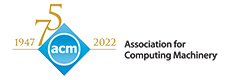

Resized Dimensions :  (120, 340, 4)


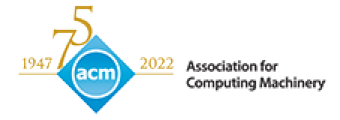

In [ ]:
import cv2
import urllib
from google.colab.patches import cv2_imshow

# filepath = r'Data/02/GCM_MIROC-ESM_RandomDay.png'
# img = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)

filepath = r'https://www.acm.org/binaries/content/gallery/global/top-menu/acm_logo_tablet.svg'
req = urllib.request.urlopen(filepath)
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img = cv2.imdecode(arr, -1) # 'Load it as it is'

print('Original Dimensions : ',img.shape)
cv2_imshow(img)

# percent of original size
scale_percent = 150
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
 
print('Resized Dimensions : ',resized.shape)
 
cv2_imshow(resized)

## Resizing vs Regridding

![](https://www.researchgate.net/publication/326818209/figure/fig2/AS:655719716110336@1533347171910/Regridding-original-values-are-available-for-the-grid-indicated-by-grey-lines-new.png)

**Figure:** 

* Regridding: original values are available for the grid indicated by grey lines, new values are required for the black lined grid (e.g., the red cell), or vice versa (e.g., the green cell). 
* New cell values can be calculated from the intersecting grid areas (lower left), intersecting grid cell centre points (lower right), or using interpolation (e.g., from black cells or cell center points to the green cell).

## Regridding using xarray.interp()

In [ ]:
filepath = r'Data/01/IMD_2000.nc'
ds = xr.open_dataset(filepath)
ds

<xarray.Dataset>
Dimensions:  (time: 12, lat: 129, lon: 135)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2000-12-01
  * lat      (lat) float64 6.5 6.75 7.0 7.25 7.5 ... 37.5 37.75 38.0 38.25 38.5
  * lon      (lon) float64 66.5 66.75 67.0 67.25 67.5 ... 99.25 99.5 99.75 100.0
Data variables:
    rain     (time, lat, lon) float64 ...

In [ ]:
ds.close()

In [ ]:
filepath = r'Data/01/MIROC-ESM.nc'
ds = xr.open_dataset(filepath)
ds

<xarray.Dataset>
Dimensions:    (time: 2190, bnds: 2, lat: 12, lon: 12)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01T12:00:00 ... 2005-12-31T12:00:00
  * lat        (lat) float64 6.977 9.767 12.56 15.35 ... 29.3 32.09 34.88 37.67
  * lon        (lon) float64 67.5 70.31 73.12 75.94 ... 90.0 92.81 95.62 98.44
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    pr         (time, lat, lon) float32 ...
Attributes: (12/27)
    institution:            JAMSTEC (Japan Agency for Marine-Earth Science an...
    institute_id:           MIROC
    experiment_id:          historical
    source:                 MIROC-ESM 2010 atmosphere: MIROC-AGCM (MIROC-AGCM...
    model_id:               MIROC-ESM
    forcing:                GHG, SA, Oz, LU, Sl, Vl, MD, BC, OC
    ...                     ...
    table_id:               Table day (26 July 2011) f21c16b785432e6bd3f72e80...
    title:                  MIROC-ESM model output prepared for CMIP5 historical
    parent_experiment:      pre-industrial control
    modeling_realm:         atmos
    realization:            1
    cmor_version:           2.7.1

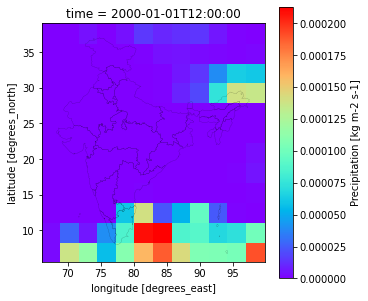

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
ds['pr'][0,:,:].plot(cmap = 'rainbow', ax = ax, vmin = np.min(ds['pr'][0,:,:].values), vmax = np.max(ds['pr'][0,:,:].values))
map_df.plot(edgecolor="black", facecolor="None", ax = ax, linewidth = 0.1)

In [ ]:
projection_dimension = [129, 135]
lat_bnds, lon_bnds = [6.5, 38.5], [66.5, 100]
lat_lst = np.linspace(lat_bnds[0], lat_bnds[1], projection_dimension[0])
lon_lst = np.linspace(lon_bnds[0], lon_bnds[1], projection_dimension[1])
print(lat_lst[1]-lat_lst[0], lon_lst[1]-lon_lst[0])
print(len(lat_lst), len(lon_lst))

0.25 0.25
129 135


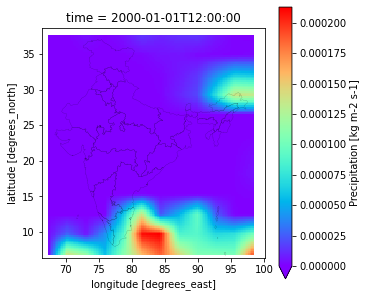

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
ds1 = ds.interp(lat = lat_lst, lon = lon_lst)
ds1['pr'][0,:,:].plot(cmap = 'rainbow', ax = ax, vmin = np.min(ds['pr'][0,:,:].values), vmax = np.max(ds['pr'][0,:,:].values))
map_df.plot(edgecolor="black", facecolor="None", ax = ax, linewidth = 0.1)

In [ ]:
ds.close()
ds1.close()

**Questions**:
1. Is regridding the same as resizing?
2. OpenCV only needed the new dimensions, but xarray asked for the lat-lon grid. Why so?
3. How does this affect us? 

# Single Image SR using interpolation schemes

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
model = hub.load("https://tfhub.dev/captain-pool/esrgan-tf2/1")

In [ ]:
filepath = r'https://www.acm.org/binaries/content/gallery/global/top-menu/acm_logo_tablet.svg'
req = urllib.request.urlopen(filepath)
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img = cv2.imdecode(arr, -1)
img.shape

(80, 227, 4)

In [ ]:
#load_image() # Low Resolution Image of shape [batch_size, height, width, 3]
low_resolution_image = img.reshape(1,img.shape[0],img.shape[1],img.shape[2])[:,:,:,:-1] 
low_resolution_image = tf.cast(low_resolution_image, tf.float32)
super_resolution = model(low_resolution_image) # Perform Super Resolution here
super_resolution.shape

TensorShape([1, 320, 908, 3])

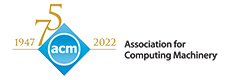

In [ ]:
cv2_imshow(img)
# cv2_imshow(img[:,:,:-1])

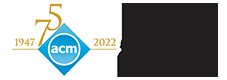

In [ ]:
cv2_imshow(low_resolution_image.numpy().reshape(low_resolution_image.shape[1:]))

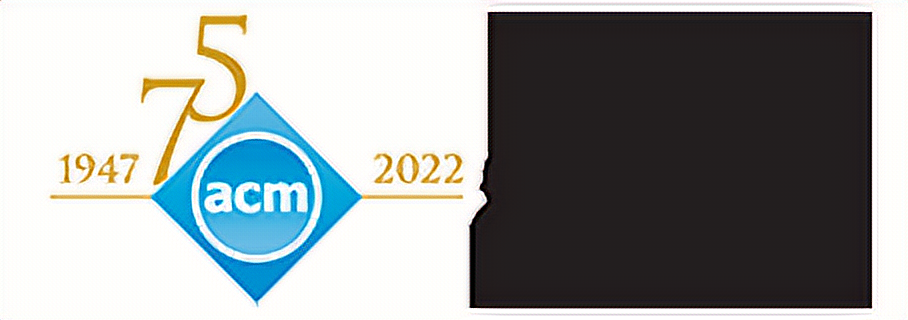

In [ ]:
cv2_imshow(super_resolution.numpy().reshape(super_resolution.shape[1:]))

# Downscaling using [SRCNN](https://github.com/tegg89/SRCNN-Tensorflow)

The simplest CNN based architecture I came across which dealt with super-resolution.

In [ ]:
import skimage
skimage.__version__

'0.18.3'

In [ ]:
from skimage.metrics import structural_similarity as ssim
import math

In [ ]:
'''
The below defined metrics can be used to assess quality of super-resolution
Not used here, but you are encouraged to play with it.
'''
def psnr(target, ref):         
    # assume RGB image
    target_data = target.astype(float)
    ref_data = ref.astype(float)
    print(target_data.shape)
    print(ref_data.shape)
    diff = ref_data - target_data
    diff = diff.flatten('C')
    rmse = math.sqrt(np.mean(diff ** 2.))
    return 20 * math.log10(255. / rmse)

def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])    
    return err

def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel =True))    
    return scores


In [ ]:
def model(height = 32, width = 32):
    # define model type
    SRCNN = keras.models.Sequential()
    # add model layers
    SRCNN.add(keras.layers.Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(height, width, 1)))
    SRCNN.add(keras.layers.Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(keras.layers.Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))
    adam = tf.keras.optimizers.Adam(lr=0.0003)
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    return SRCNN


In [ ]:
srcnn_model = model()
srcnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 128)       10496     
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        73792     
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 1)         1601      
                                                                 
Total params: 85,889
Trainable params: 85,889
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


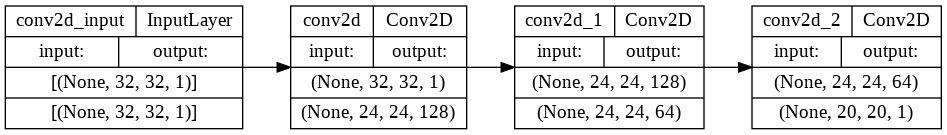

In [ ]:
tf.keras.utils.plot_model(srcnn_model, show_shapes = True, rankdir='LR')

In [ ]:
srcnn_model.load_weights(r'3051crop_weight_200.h5')

In [ ]:
filepath = r'https://www.acm.org/binaries/content/gallery/global/top-menu/acm_logo_tablet.svg'
req = urllib.request.urlopen(filepath)
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img = cv2.imdecode(arr, -1) # 'Load it as it is'
img.shape

(80, 227, 4)

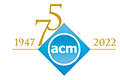

In [ ]:
cv2_imshow(img[:,:120,:])

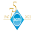

In [ ]:
resized = cv2.resize(img[:,:120,:], (32,32), interpolation = cv2.INTER_AREA)
cv2_imshow(resized)

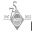

In [ ]:
cv2_imshow(cv2.cvtColor(resized, cv2.COLOR_RGB2GRAY))
temp = cv2.cvtColor(resized, cv2.COLOR_RGB2GRAY)
Y = np.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
Y[0, :, :, 0] = temp[:, :].astype(float) / 255
pre = srcnn_model.predict(Y, batch_size=1)
pre *= 255
pre[pre[:] > 255] = 255
pre[pre[:] < 0] = 0
pre = pre.astype(np.uint8)

In [ ]:
print(temp.shape, Y.shape, pre.shape)

(32, 32) (1, 32, 32, 1) (1, 20, 20, 1)


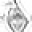

In [ ]:
img_new = np.array(temp)
img_new[:,:] = cv2.resize(pre.reshape(20,20), (32,32), interpolation = cv2.INTER_AREA)
cv2_imshow(img_new)

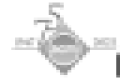

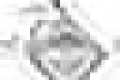

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [ ]:
plt.figure(figsize = (10,10))
cv2_imshow(cv2.resize(temp, (120,80), interpolation = cv2.INTER_AREA))

plt.figure(figsize = (10,10))
cv2_imshow(cv2.resize(img_new, (120,80), interpolation = cv2.INTER_AREA))

# Downscaling Using [ConvLSTM](https://ieeexplore.ieee.org/document/9348885)


## Study Region
![](https://raw.githubusercontent.com/dubeysarth/Lab_Downscaling/main/Data/Study_region.png)

In [ ]:
from ConvLSTM import *

In [ ]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    print([x.name for x in local_device_protos if x.device_type == 'GPU'])
get_available_gpus()

['/device:GPU:0']


In [ ]:
Aug_ConvLSTM_model = AugementedConvLSTM(
    projection_height = 32, 
    projection_width = 32,
    timesteps=4
    )
model = Aug_ConvLSTM_model.model(
    [16, 8, 8], 
    [4,2,1], 
    [32,16,1], 
    [4,1,2], 
    2
    )
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4, 32, 32,   0           []                               
                                7)]                                                               
                                                                                                  
 conv_lstm2d (ConvLSTM2D)       (None, 4, 32, 32, 1  23616       ['input_1[0][0]']                
                                6)                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 4, 32, 32, 1  64         ['conv_lstm2d[0][0]']            
 alization)                     6)                                                            

In [ ]:
data = glob.glob(os.path.join('Data', '03', 'MIROC-ESM', "[0-9]*.npy"), recursive=True)
sort_nicely(data)

labels = glob.glob(os.path.join('Data', '03', 'IMD', "[0-9]*.npy"), recursive=True)
sort_nicely(labels)
print(len(data), len(labels))

2190 2190


In [ ]:
split_ratio = 0.15

In [ ]:
partition = {}
split_idx = len(labels) - int(len(data)*0.15)
split_idx

1862

In [ ]:
train_examples = [(data[i], labels[i]) for i in itertools.islice(range(len(data)), 0, split_idx, 1)]
partition['train'] = train_examples

In [ ]:
val_examples = [(data[i], labels[i]) for i in itertools.islice(range(len(data)), split_idx, None, 1)]
partition['val'] = val_examples

In [ ]:
params = {'dim': (32, 32),
          'batch_size': 15,
          'timesteps' : 4,
          'shuffle': False}
# Define the generators
training_generator = DataGenerator(partition['train'], **params)
validation_generator = DataGenerator(partition['val'], **params)

import itertools
for xx, yy in itertools.islice(training_generator, 0, 1, 1):
    print(xx.shape, yy.shape)
# (15, 4, 129, 135, 7) (15, 129, 135, 1)
# (15, 4, 32, 32, 7) (15, 32, 32, 1) 

(15, 4, 32, 32, 7) (15, 32, 32, 1)


In [ ]:
history = train(
    model,
    training_generator, 
    validation_generator,
    std_observed = 10,
    epochs = 128
    )

Epoch 1/128
31/31 [==============================] - ETA: 0s - loss: 0.8649 - root_mean_squared_error: 0.8649 - actual_rmse_loss: 8.6486
Epoch 1: val_loss improved from inf to 0.87533, saving model to convlstm_weights_pr_toy.h5
31/31 [==============================] - 14s 162ms/step - loss: 0.8649 - root_mean_squared_error: 0.8649 - actual_rmse_loss: 8.6486 - val_loss: 0.8753 - val_root_mean_squared_error: 0.8753 - val_actual_rmse_loss: 8.7533 - lr: 3.0000e-04
Epoch 2/128
31/31 [==============================] - ETA: 0s - loss: 0.8197 - root_mean_squared_error: 0.8197 - actual_rmse_loss: 8.1970
Epoch 2: val_loss improved from 0.87533 to 0.87082, saving model to convlstm_weights_pr_toy.h5
31/31 [==============================] - 5s 148ms/step - loss: 0.8197 - root_mean_squared_error: 0.8197 - actual_rmse_loss: 8.1970 - val_loss: 0.8708 - val_root_mean_squared_error: 0.8708 - val_actual_rmse_loss: 8.7082 - lr: 3.0000e-04
Epoch 3/128
31/31 [==============================] - ETA: 0s - loss

In [ ]:
for xx, yy in itertools.islice(training_generator, 0, 1, 1):
    print(xx.shape, yy.shape)
    temp = model.predict(xx)

# std: 11.080416833336841; Mean: 2.924777858185797
pr_mean = 3
pr_std = 11

(15, 4, 32, 32, 7) (15, 32, 32, 1)


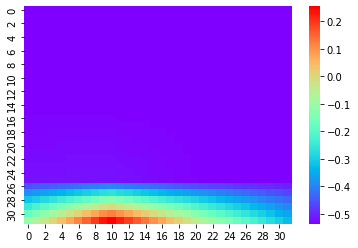

In [ ]:
# xx[0,-1,:,:,0].shape
sns.heatmap(xx[3,-1,:,:,0], cmap = 'rainbow', cbar = True)

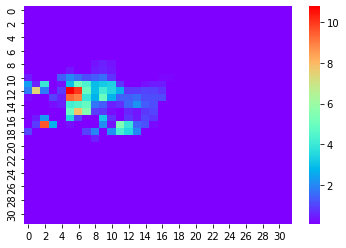

In [ ]:
# yy[-1,:,:,0].shape
sns.heatmap((yy[3,:,:,0]*pr_std) + pr_mean, cmap = 'rainbow', cbar = True)

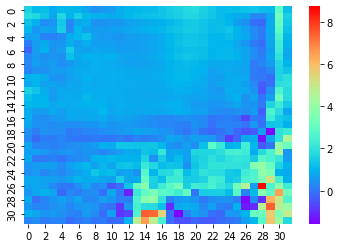

In [ ]:
sns.heatmap((temp[3,:,:,0]*pr_std) + pr_mean, cmap = 'rainbow', cbar = True)

# At-Scale Downscaling Results from ConvLSTM

## Downscaled outputs for MIROC-ESM 
![](https://raw.githubusercontent.com/dubeysarth/Lab_Downscaling/main/Data/MIROC-ESM_Downscaled.gif)

![](https://raw.githubusercontent.com/dubeysarth/Lab_Downscaling/main/Data/02/MIROC-ESM_rmse.png)

![](https://raw.githubusercontent.com/dubeysarth/Lab_Downscaling/main/Data/02/MIROC-ESM_rmse99.png)